In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

In [2]:
mnist = fetch_openml("mnist_784", version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"],mnist["target"]
X.shape # i.e 784 => 28 x 28 pixels

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

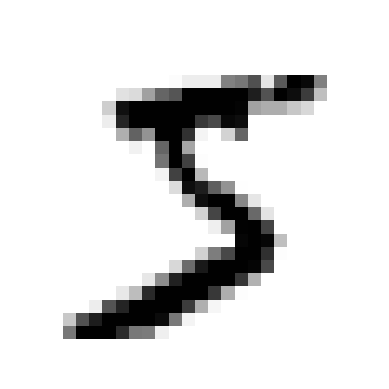

In [7]:
X_array = X.to_numpy()
some_digit = X_array[0] # X is a dataframe matplotlib can not do these on Dataframe it needs array
some_digit_image = some_digit.reshape(28,28) # converts the 784 images to 28 x 28 array

plt.imshow(some_digit_image,cmap="binary")
plt.axis("off")
plt.show()

In [8]:
y[0] # y is a array

'5'

In [9]:
y = y.astype(np.uint8)
y[0] # since most of ML algos expect numbers we converted them to numbers 

np.uint8(5)

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] # first 60k train next 20k test

# Training a binary classifier
**Binary classifier classifies 2 classes , here we are classifying 5 and not 5**

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## **Stochastic Gradient Descent Classifier**
It deals with training data one at a time used for online learning

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

C:\Users\haari\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# Performance Measures

## Measuring Accuracy using Cross Validation

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [15]:
skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_folds = X_train.iloc[test_index]
    y_test_folds = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

90% accuracy, this is because if we guess 10% images are 5s and if we guess an image is not 5 then 90% of time it is right.
Beats Nostradamus
\so accuracy is not taken as measure in classification especially when we are dealing with skewed data

# Confusion Matrix

Its generally to check and find out how many times a class A is classified as Class B i.e how many times did it get confused

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

rows represent actual class and columns represent predicted class

In [22]:
# 5    not5
# not5  5

In [23]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

accuracy of positive predictions ---> Precision = TP/TP+FP

If classifier classifies only 1 instance correct and leave remaining instances even then precision = 100%, so algo might prefer this to improve but then it ignores all instances but one.
So it is used with another metric recall, also called sensitivity or true positive rate

Recall = TP/TP+FN

## Precision and recall

In [24]:
from sklearn.metrics import precision_score,recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [25]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

To get better results we use F1 score which is harmonic mean of precision and recall
regular mean treats all values equally but harmonic mean gives more weight to low values. So unless both the values are high F1 score wont be high

In [26]:
from sklearn.metrics import f1_score 

f1_score(y_train_5, y_train_pred)

0.7325171197343847

Here classifier favours good recall and precision
but it is not necessary to follow the same always for example if we are classifing childrens videos then we search for precision
because we need safe videos even if we miss few good videos

increasing precision reduces recall this is called precision-recall tradeoff

# Precision Recall Trade-Off

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

C:\Users\haari\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [28]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [29]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5, cv=3,method="decision_function")

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

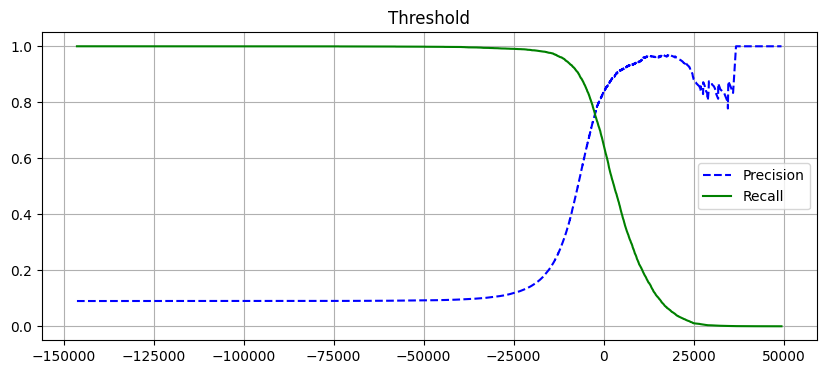

In [31]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.figure(figsize=(10,4))
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds, recalls[:-1],"g-",label="Recall")
    plt.title("Threshold")
    plt.grid(True)
    plt.legend()

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

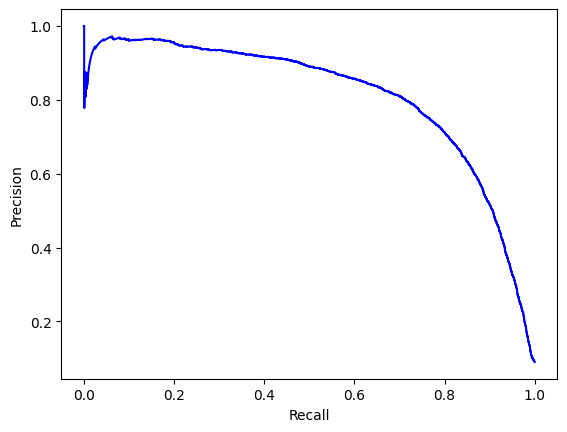

In [32]:
plt.plot(recalls[:-1],precisions[:-1],"b-")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [33]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # if we decide to have 90% precision then we look for first index that gives more than 90% precision
threshold_90_precision

np.float64(3370.0194991439557)

In [34]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [35]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [36]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

# The ROC curve

Reciever Operating charecteristics curve - Instead of plotting precision vs recall it plots true positive rate(recall) against fasle positive rate(= 1- True Neg rate(specificity))

In [37]:
from sklearn.metrics import roc_curve

In [38]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [39]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

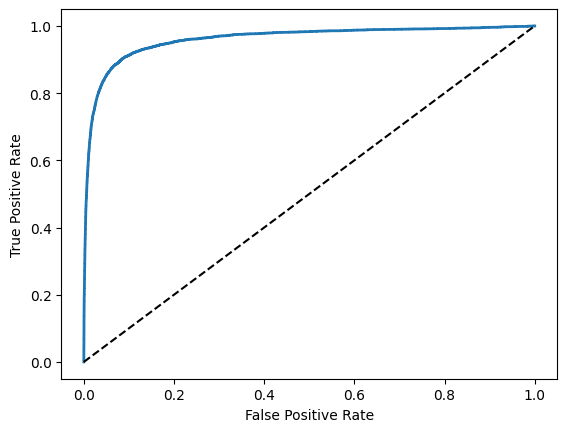

In [40]:
plot_roc_curve(fpr,tpr)
plt.show()

A perfect classifier has Area Under the Curve(AUC) = 1 and purely random classifier has AUC =0.5 

In [41]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

Prefer PR curve when +ve classs is rare or when we care about false +ves than false -ves

Let us test this with RandomForestClassifier since there are only few +ves(5s) and lots of -ves(non 5s) the score is higher.

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train,y_train_5,cv=3,method="predict_proba")

ROC expects labels and scores but here predict_proba() method gives probability of an instance belonging to a class so we will be giving probabilities

In [44]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

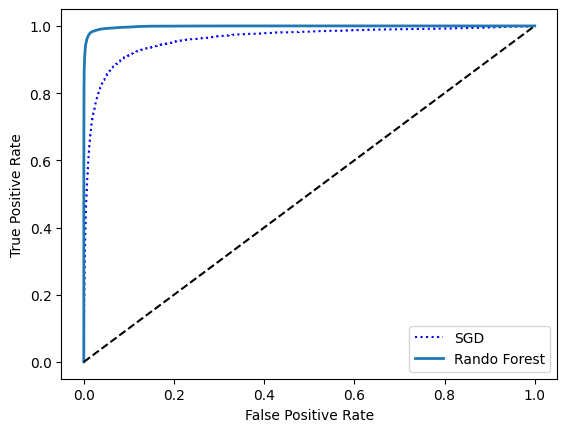

In [45]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Rando Forest")
plt.legend(loc="lower right")
plt.show()

In [46]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

1. Choose appropriate metric 
2. evaluate classifier using cross-validation
3. select precision/recall trade offs according to task
4. evaluate using ROC , ROC AUC scores

# MULTICLASS CLASSIFICATION

using Binary Classifier => We mmake 10 binary classifier one for each digit and use the decision score fromm all and classify based on highest score this method is called OvR=one versus the rest.

OvO=one versus one --> Here we classify any 2 classes i.e 0s and 1's and so on the adv here is we only nneed to feed required data---> SVM prefers this because SVM can train faster smaller sets than larger ones but for remaining binary classifiers OvR is preferred

When we use Binary Classifiers for Multiclass scikit learn automatically detects and uses OvR or OvO based on algo

In [47]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

C:\Users\haari\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

Here SVM classifies trys out 45 combinations using OvO and based on highest decision score it has predicted

In [48]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

C:\Users\haari\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

This is the proof for it there are 10 scores and 5's is the highest

In [49]:
np.argmax(some_digit_scores)

np.int64(5)

In [50]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [51]:
svm_clf.classes_[5]

np.uint8(5)

When model is trained svm stores its targets in order in classes array

In [52]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])

C:\Users\haari\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\haari\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\haari\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\haari\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\haari\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature na

array([5], dtype=uint8)

In [53]:
len(ovr_clf.estimators_)

10

In [54]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

C:\Users\haari\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [55]:
sgd_clf.decision_function([some_digit])

C:\Users\haari\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [56]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [60]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled, y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

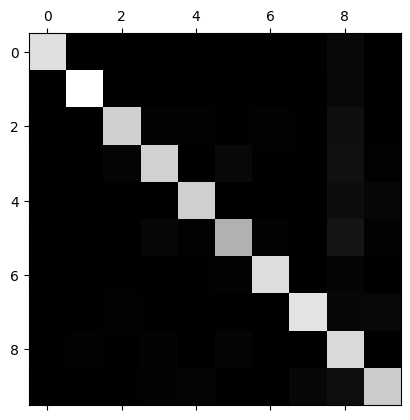

In [61]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [90]:
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / row_sums

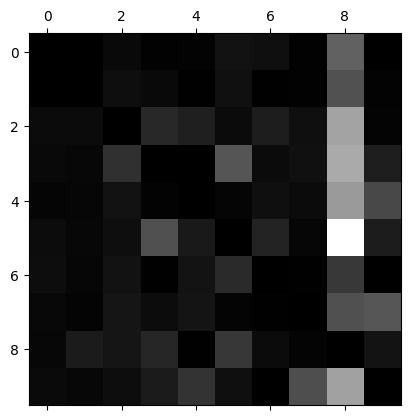

In [92]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [104]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


AttributeError: 'str' object has no attribute 'reshape'

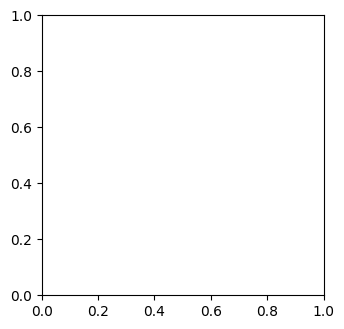

In [105]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Multilabel Classification

In [69]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [70]:
knn_clf.predict([some_digit])

C:\Users\haari\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [72]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train,y_multilabel,cv=3)
f1_score(y_multilabel,y_train_knn_pred, average="macro")

0.9764102655606048

# Multioutput Classificaton

In [73]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

IndexError: tuple index out of range

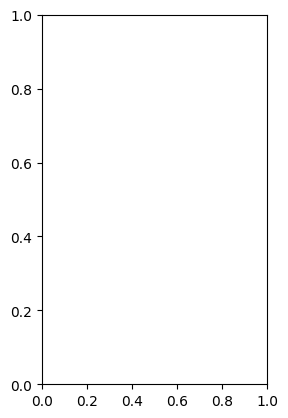

In [101]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()